<a href="https://colab.research.google.com/github/Spin-Chemistry-Labs/radicalpy/blob/main/examples/tutorials/02_chemical_kinetics_and_molecular_motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2 - Chemical kinetics and molecular motion



&copy; Lewis M. Antill, 2025

This tutorial will introduce chemical kinetics and molecular motion. We will learn how to simulate radical pair reactions with chemical rate equations and also understand how a radical pair behaves in a solvent cage, where molecules can separate and re-encounter numerous times before they escape the surrounding solvent cage to form free radicals. 

In [ ]:
!pip install radicalpy

In [1]:
import ipywidgets as wdg
import matplotlib.pyplot as plt
import numpy as np
import radicalpy as rp
from radicalpy.classical import latexify, latex_eqlist_to_align, Rate, RateEquations

---

### How are radical pairs created?

For details on photochemistry, the book entitled "[Principles of Molecular Photochemistry: An Introduction](https://www.amazon.com/Principles-Molecular-Photochemistry-Nicholas-Turro/dp/1891389572/ref=pd_bxgy_img_sccl_2/146-7842833-3906529?pd_rd_w=Bfz7q&pf_rd_p=6b3eefea-7b16-43e9-bc45-2e332cbf99da&pf_rd_r=TBGB1BV63JRD9X6KFS3N&pd_rd_r=c48cf623-4f43-4c15-bf52-a1cbfd66f508&pd_rd_wg=MJK1E&pd_rd_i=1891389572&psc=1)" is recommended. Radicals are common reaction intermediates in numerous light-induced chemical processes. Spin-correlated radical pairs are produced in various ways, 

1) [Photoinduced electron transfer reactions](https://en.wikipedia.org/wiki/Photoinduced_electron_transfer),

$$^{1/3}D + A \xrightarrow{} ^{1/3}\bigl[D^{\bullet+} + A^{\bullet-}\bigr]$$

Here $A$ and $D$ represent acceptor and donor, respectively. The $^1$ represents singlet state molecules and $^3$ for triplet state molecules. The $^\bullet$ symbol denotes the radical state. This reaction produces a radical ion pair.

2) [Photodecomposition reactions](https://en.wikipedia.org/wiki/Photodissociation),

$$^{1/3}A - B \xrightarrow{} ^{1/3}[A^{\bullet} + B^{\bullet}]$$

$A-B$ bond cleavage produces a radical pair involving both $A$ and $B$ molecules.

3) Photoreduction reactions,

$$^{1/3}M + RH \xrightarrow{} ^{1/3}[MH^{\bullet} + R^{\bullet}]$$

[Hydrogen abstraction](https://en.wikipedia.org/wiki/Hydrogen_atom_abstraction) reactions occur from $M$ producing a radical pair between $MH$ and the radical formed from the hydrogen donor ($RH$).

Radical pairs inherit the spin state of their precursor. Most molecules are singlet when in their [ground state](https://en.wikipedia.org/wiki/Ground_state), where triplet states are typically only transient (short-lived) species, which can be formed in the above reactions upon light excitation and ensuing [intersystem crossing](https://en.wikipedia.org/wiki/Intersystem_crossing). Two radicals on the same molecule ($A^\bullet - B^\bullet$) are known as biradicals, an example of such a radical pair is flavin adenine dinucleotide (FAD), where a radical pair is formed between the isoalloxazine ring and adenine moiety of the molecule (see [here](https://pubs.acs.org/doi/abs/10.1021/jp0519722) and [here](https://pubs.acs.org/doi/abs/10.1021/acs.jpclett.8b01088)).

---

### Radical pair reactions with the relaxation mechanism

The [relaxation mechanism](https://www.journal.csj.jp/doi/abs/10.1246/bcsj.57.322) (RM) describes how the spin dynamics of radical pairs alter when they are confined in some way, *e.g.*, in viscous solvents, proteins, micelles, vesicles, or linked systems, and the radical pair or biradical lifetime can become comparable to the spin relaxation time. 

The following figure depicts the principles of RM in the presence and absence of an external magnetic field ($B_0$). Cage recombination only occurs from the singlet radical pair with a rate constant, $k_R$ and free radicals are formed at a rate $k_E$. The <font color='orange'>S</font><font color='purple'>T</font>-mixing rate is $k_{ST}$ and spin relaxation between <span style="color: purple;">T<sub>+,-</sub></span>
-<span style="color: purple;">T<sub>0</sub></span>
 and <span style="color: purple;">T<sub>0</sub></span>-<font color='orange'>S</font> are given the rate constants $k_{Rlx}$ and $k_{Rlx'}$, respectively.

<img src="figures/RM.png" width="700" height="300" align="center"/>

For MFEs to develop, the rates of reaction of the different spin states must be different. Radical pairs can undergo recombination to the ground state via back electron transfer (BET) or a non-radiative (or radiative) transition back to the ground state (geminate recombination). Only the <font color='orange'>singlet</font> RP returns to the ground state and the quantum yields of this reaction are directly influenced by MFEs on the singlet character of the RP. 

Both spin states of the RP (<font color='orange'>singlet</font> and <font color='purple'>triplet</font>) can undergo spin decoherence in confined systems or escape products in solution-based systems, which typically give rise to long-lived species that can lead to large MFEs. These long-lived products must also have an appreciable steady-state concentration as the photocycle accumulates over the course of multiple turnovers.

Let's look at the three cases, when $B_0 = 0$, <font color='orange'>singlet</font>-precursor at $B_0 >> HFC$, and <font color='purple'>triplet</font>-precursor at $B_0 >> HFC$. Here we have used one relaxation rate for simplicity.

In [2]:
S, Tp, T0, Tm = "S", "T_+", "T_0", "T_-"
init_states = {
"S": {S: 1},
"T": {Tp: 1 / 3, T0: 1 / 3, Tm: 1 / 3}
}

def radicalpair_kinetics(tmax, init_state, krec, kesc, krelax):
    # kinetic parameters
    ke = Rate(kesc, "k_{E}")  # geminate RP to free radical separation
    kst = Rate(8e7, "k_{ST}")  # ST-mixing rate
    krlx = Rate(krelax, "k_{Rlx}")  # RP relaxation rate
    kr = Rate(krec, "k_{R}")  # reverse electron transfer of RP to groundstate

    # Rate equations
    off = {}
    off[S] = {S: -(3 * kst + kr + ke), Tp: kst, T0: kst, Tm: kst}
    off[Tp] = {Tp: -(2 * kst + ke), S: kst, T0: kst}
    off[T0] = {T0: -(3 * kst + ke), S: kst, Tp: kst, Tm: kst}
    off[Tm] = {Tm: -(2 * kst + ke), S: kst, T0: kst}

    on = {}
    on[S] = {S: -(kst + 2 * krlx + kr + ke), Tp: krlx, T0: kst, Tm: krlx}
    on[Tp] = {Tp: -(2 * krlx + ke), S: krlx, T0: krlx}
    on[T0] = {T0: -(kst + 2 * krlx + ke), S: kst, Tp: krlx, Tm: krlx}
    on[Tm] = {Tm: -(2 * krlx + ke), S: krlx, T0: krlx}

    initial_states = init_states[init_state]
    time = np.arange(0, tmax, 1e-9)

    re_off = RateEquations(off)
    re_on = RateEquations(on)
    result_off = re_off.time_evolution(time, initial_states)
    result_on = re_on.time_evolution(time, initial_states)

    keys = [S, Tp, T0, Tm]
    rp_field_off = result_off[keys]
    rp_field_on = result_on[keys]
    rp_delta_delta_A = rp_field_on - rp_field_off

    plt.clf()
    fig = plt.figure()
    scale = 1e6
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True)
    axs[0].plot(time * scale, rp_field_off, color="blue", linewidth=4)
    axs[0].plot(time * scale, rp_field_on, color="green", linewidth=4)
    axs[1].plot(time * scale, rp_delta_delta_A, color="orange", linewidth=4)
    plt.xscale("linear")
    axs[0].legend([r"$B_0 = 0$", r"$B_0 \neq 0$"], fontsize=14)
    axs[1].set_xlabel(r"Time / $\mu s$", size=14)
    axs[0].set_ylabel(r"$\Delta A$", size=14)
    axs[1].set_ylabel(r"$\Delta \Delta A$", size=14)
    axs[0].tick_params(labelsize=14)
    axs[1].tick_params(labelsize=14)
    fig.set_size_inches(10, 5)

    # print(latex_eqlist_to_align(latexify(off)))

@wdg.interact(tmax = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.linspace(5e-8, 2e-6, 100)]),
              init_state = ['S', 'T'],
              krec = wdg.FloatSlider(min=0, max=1e10, step=1e6, value=1e8),
              kesc = wdg.FloatSlider(min=0, max=1e8, step=1e6, value=1e6),
              krelax = wdg.FloatSlider(min=0, max=1e8, step=1e6, value=2e6))              
def update(tmax=0.0, init_state='S', krec=0.0, kesc=0.0, krelax=0.0):radicalpair_kinetics(tmax, init_state, krec, kesc, krelax)

interactive(children=(SelectionSlider(description='tmax', options=(('5e-08', np.float64(5e-08)), ('6.9697e-08'…

---

### Experimental example - flavin adenine dinucleotide (FAD) at pH 2.3

Flavin adenine dinucleotide (FAD) is a special case, where the radical pair is in equilibrium with the triplet excited state and consequently exhibits magnetic field effects (MFEs) on both the radical pair and triplet excited state (see [here](https://pubs.acs.org/doi/abs/10.1021/jp0519722) and [here](https://pubs.acs.org/doi/abs/10.1021/acs.jpclett.8b01088)). We have also included a triplet state quencher in the form of tryptophan.

<img src="figures/fad_trp.png" width="1100" height="300" align="center"/>

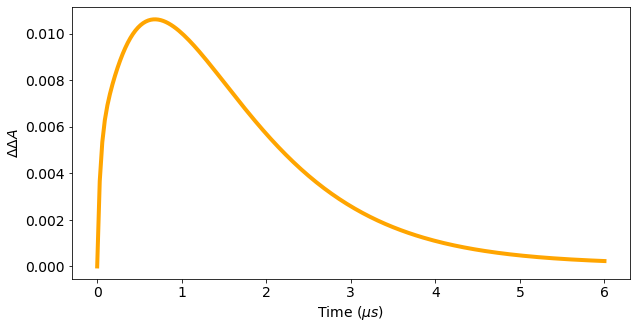

In [ ]:
kex = Rate(0, "k_{ex}")  # groundstate excitation rate
kfl = Rate(3.55e8, "k_{fl}")  # fluorescence rate
kic = Rate(1.28e9, "k_{IC}")  # internal conversion rate
kisc = Rate(3.64e8, "k_{ISC}")  # intersystem crossing rate
khfc = Rate(8e7, "k_{HFC}")  # spin-state mixing rate
kd = Rate(3e5, "k_d")  # protonated triplet to ground state
k1 = Rate(7e6, "k_1")  # protonated triplet to RP
km1 = Rate(2.7e9, "k_{-1}")  # RP to protonated triplet
krt = Rate(1e9, "k^R_T")  # triplet state relaxation rate
kbet = Rate(1.3e7, "k_{BET}")  # singlet recombination
kr = Rate(1.7e6, "k_R")  # RP relaxation

# Quenching kinetic parameters
kq = Rate(0, "k_q")  # 1e9  # quenching rate
kp = Rate(0, "k_p")  # 3.3e3  # free radical recombination
Q = Rate(0, "Q")  # 1e-3  # quencher concentration

pH = 2.3
Hp = 10 ** (-1 * pH)  # concentration of hydrogen ions

# Rate equations
base = {}
base["S0"] = {
    "S0": -kex,
    "T*+/-": kd,
    "T*0": kd,
    "S": kbet,
    "S*": kfl + kic,
    "Quencher": kp,
}
base["S*"] = {
    "S*": -(kfl + kic + 3 * kisc),
    "S0": kex,
}
base["T*+/-"] = {
    "T*+/-": -(kd + k1 + krt),
    "T+/-": km1 * Hp,
    "T*0": 2 * krt,
    "S*": 2 * kisc,
}
base["T*0"] = {
    "T*0": -(kd + k1 + 2 * krt),
    "T0": km1 * Hp,
    "T*+/-": krt,
    "S*": kisc,
}
base["Quencher"] = {
    "Quencher": -kp,
    "T*+/-": kq * Q,
    "T*0": kq * Q,
}

off = {}
off["S"] = {
    "S": -(3 * khfc + kbet),
    "T+/-": khfc,
    "T0": khfc,
}
off["T+/-"] = {
    "T+/-": -(2 * khfc + km1 * Hp),
    "S": 2 * khfc,
    "T0": 2 * khfc,
    "T*+/-": k1,
}
off["T0"] = {
    "T0": -(3 * khfc + km1 * Hp),
    "S": khfc,
    "T+/-": khfc,
    "T*0": k1,
}

on = {}
on["S"] = {
    "S": -(2 * kr + khfc + kbet),
    "T+/-": kr,
    "T0": khfc,
}
on["T+/-"] = {
    "T+/-": -(2 * kr + km1 * Hp),
    "S": 2 * kr,
    "T0": 2 * kr,
    "T*+/-": k1,
}
on["T0"] = {
    "T0": -(2 * kr + khfc + km1 * Hp),
    "S": khfc,
    "T+/-": kr,
    "T*0": k1,
}

initial_states = {
    "T+/-": 2 / 3,
    "T0": 1 / 3,
}
time = np.linspace(0, 6e-6, 200)

re_off = RateEquations({**base, **off})
re_on = RateEquations({**base, **on})
result_off = re_off.time_evolution(time, initial_states)
result_on = re_on.time_evolution(time, initial_states)
fac = 0.07

keys = ["S", "T+/-", "T0", "Quencher"] + 2 * ["T*+/-", "T*0"]
field_off = fac * result_off[keys]
field_on = fac * result_on[keys]
delta_delta_A = field_on - field_off

scale = 1e6
plt.clf()
ax = plt.gca()

plt.plot(time * scale, delta_delta_A, color="orange", linewidth=4)
ax.set_xlabel("Time ($\mu s$)", size=14)
ax.set_ylabel("$\Delta \Delta A$", size=14)
ax.tick_params(labelsize=14)
plt.gcf().set_size_inches(10, 5)
plt.show()

---

### Radical pair reactions in solution

The below reaction scheme depicts the usual fates during a transient radical pair reaction in solution. Radical pairs are short-lived intermediates produced via electron transfer, decomposition, or hydrogen transfer reactions from <font color='orange'>S-</font> (<font color='orange'>singlet</font>) or <font color='purple'>T</font> (<font color='purple'>triplet</font>) precursors, where reactions occuring from <font color='blue'>free radicals</font> and its precursors are called F-precursors. The dynamic behaviour of radical pairs produced from <font color='purple'>T</font> and F-precursors are similar in nature, producing similar reaction results. 

A radical pair is generated while surrounded by solvent molecules, known as "[solvent cages or cage effect](https://en.wikipedia.org/wiki/Cage_effect)" and preserves the spin multiplicity of its precursor (*i.e.*, <font color='orange'>singlet</font> or <font color='purple'>triplet</font>). The two radicals are produced in close proximity and are known as "close pairs", which can recombine to the ground state to produce "cage products" through <font color='orange'>S-</font>close pairs immediately after radical pair formation (primary recombination).

Close pairs containing light atom-centred radicals (*e.g.*, C-, N-, and O-) do not undergo <font color='orange'>S</font><font color='purple'>T</font>-mixing due to the large exchange interaction. However, if the close pairs possess heavy atom-centred radicals (*e.g.*, S-, P-, Si-, Ge-, and Sn-), <font color='orange'>S</font><font color='purple'>T</font>-mixing is possible through spin-orbit coupling ([SOC](https://en.wikipedia.org/wiki/Spin%E2%80%93orbit_interaction)). This tutorial will only concern itself with light atom-centred radicals. 

Now let's consider the case when the close pairs start to diffuse (typical diffusive steps $10^{-12}$ $s^{-1}$) apart into a "separated RP or separated pair". When the distance ($r$) between the two radicals is sufficiently large, the exchange interaction ($J$) is removed (or negligibly small) and <font color='orange'>S</font><font color='purple'>T</font>-mixing can occur. Some separated pairs re-encounter to form close pairs, subsequently recombining to the ground state. However, other separated pairs escape their solvent cage to form free radicals. One can see from the below figures that the timescales for secondary recombination and <font color='orange'>S</font><font color='purple'>T</font>-mixing are comparable, therefore, a change in <font color='orange'>S</font><font color='purple'>T</font>-mixing (caused by an external magnetic field and/or differences in hyperfine couplings) can alter the yield of cage and escape products.

<img src="figures/RP_reaction_scheme.png" width="400" height="300" align="center"/>

<img src="figures/Cage_effect.png" width="500" height="300" align="center"/>

In solution, a typical radical pair lifetime (coherent <font color='orange'>S</font><font color='purple'>T</font>-mixing process) of ~10 ns normally competes with diffusive dissociation (free radical formation) of the RPs. However, if the RPs are confined in some way long-lived radical pairs of >>10 ns are observed and consequently the magnetic field effect (MFE) becomes larger. Typical reaction environments, where the RPs are encapsulated or confined, also known as chemical cages are micelles, reverse micelles, vesicles, ionic liquids, and proteins. In non-viscous solvents, electron [spin-lattice](https://en.wikipedia.org/wiki/Spin%E2%80%93lattice_relaxation) ($T_1$) and [spin-spin](https://en.wikipedia.org/wiki/Spin%E2%80%93spin_relaxation) ($T_2$) relaxation (simply put, a non-equilibrium state (*e.g.*, radical pair) returns to its equilibrium state) is on the timescale of $10^{-6}$ - $10^{-4}$ s and $10^{-6}$ - $10^{-5}$ s, respectively. Therefore, spin relaxation does not usually influence magnetic field effects in non-viscous solvents.

Here we will show one method for simulating molecular diffusion and different reaction environments with [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) and [random walk](https://en.wikipedia.org/wiki/Random_walk) methods. Finally, we will look at how the reaction environment can influence electron-electron interactions, namely, *J*-coupling and dipolar (*D*-) coupling and a phenomenon known as spin dephasing.

---

### Monte Carlo method

Monte Carlo methods (or simulations) are a type of computational algorithm that uses repeated random sampling to acquire the likelihood of a range of results of occurring. The Monte Carlo method was invented by [Stainislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam) and [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann) during World War II to improve decision making whilst working on the [Manhatten project](https://en.wikipedia.org/wiki/Manhattan_Project).

A simple example of a Monte Carlo method can be considered when calculating the probability of rolling two dice. There are 36 combinations in total, which you could compute the probability by hand. The Monte Carlo method can simulate rolling the dice 20,000 times, or more, to acquire more accurate predictions.

In this tutorial we will use a Monte Carlo method to use random sampling on the direction to which the radical moves in three-dimensional (3D) space. The 3D movement is described by the [spherical coordinate system](https://en.wikipedia.org/wiki/Spherical_coordinate_system). The spherical coordinates of a point are defined as:
* The *radial distance* or *radius* is given the symbol $r$.
* The *inclination* or *polar angle* is represented by the symbol $\theta$.
* The *azimuth* or *azimuthal angle* is denoted by the symbol $\varphi$.

<img src="figures/3D_spherical.png" width="300" height="300" align="center"/>

The variables $r(t=0)$, $\theta$, and $\varphi$ will be randomised via a Monte Carlo method. 

The $x$, $y$, and $z$ axes of a molecule are rotated by the following relationships,

$$
x = \sin \theta \cos \varphi \\
y = \sin \theta \sin \varphi \\
z = \cos \theta
$$

---

### Random walk diffusion

A *random walk* is a random process that descibes a path that consists of successive random steps on some space. This idea is used to search for the price of flucuating [stock markets](https://en.wikipedia.org/wiki/Random_walk_hypothesis), a [gambler's finances](https://en.wikipedia.org/wiki/Gambler%27s_ruin), and [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). The [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) is a stochastic process providing similar behaviour to Brownian motion and can be used to describe molecular diffusion. For a particle in a known fixed position at ($t=0$) after a large number of independent steps in the random walk, the walker's position is distributed via a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) of total [variance](https://en.wikipedia.org/wiki/Variance),

$$
\sigma^2 = \frac{t}{\delta t}\epsilon^2,
$$

where $t$ is time after $t=0$, $\epsilon$ is the step size of the random walk, and $\delta t$ is the time step. For 3D space, the variance of the [diffusion equation](https://en.wikipedia.org/wiki/Diffusion_equation) is given by,

$$
\sigma^2 = 6Dt,
$$

where $D$ is the diffusion coefficient. In our simulation the diffusional motion of the radical pair will be condsidered as random jumps between two points separated by a distance $\Delta r$,

$$
\Delta r = \sqrt{6D_{AB}\Delta t},
$$

$\Delta t$ is the time interval and $D_{AB}$ is the mutual diffusion coefficient of the radical pair.

---

### Simulation for a radical pair in water

The following simulation uses the methods described above to simulate the molecular diffusion of a radical pair in water, where radical A diffuses at a distance relative to the fixed radical B. The angles $\theta$ and $\varphi$ are randomised with the `np.random.rand()` function. Where $0^\circ \leq \theta \leq 180^\circ (\pi \,rad)$ and $0^\circ \leq \varphi \leq 360^\circ (2\pi \,rad)$, which can be written in code as `theta = np.pi * np.random.rand()` and `phi = 2 * np.pi * np.random.rand()`, respectively.

We have called our RadicalPy function `randomwalk3d`. In the parentheses following the function name you can see our variables `n_steps, x_0, y_0, ...`, which we specify outside of the function and input when we call the function in our code. From this function, we can obtain the $x, y, z$ coordinates (`x, y, z`), the distance between radical A and radical B (`dist`), and the angle $\theta$ (`angle`) at each step of the Monte Carlo random walk simulation. We will use the values from `dist` and `angle` for calculating *J*- and *D*-couplings later in the tutorial. The distance is between two points in three dimensions is given by,

$$
PQ = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}
$$

The starting radical A and radical B separation is 0.5 nm. The $r_{min}$ value of 0.5 nm is the distance at which typical organic molecules collide.

In [4]:
def monte_carlo_free(tmax, diffusion, plot=True):
    np.random.default_rng(42)

    t = np.arange(0, tmax, 40e-12)
    r_min = 0.5e-9 / 2
    r_max = 0
    r = r_min * 2
    x0, y0, z0 = r, 0, 0
    mutual_diffusion = diffusion / 10000

    delta_r = rp.classical.get_delta_r(mutual_diffusion, t[1] - t[0])
    pos, dist, ang = rp.classical.randomwalk_3d(
        len(t), x0, y0, z0, delta_r, r_min, r_max
    )

    if plot:
        rp.plot.monte_carlo_caged(pos, r_max)
    return pos, dist, ang, t

@wdg.interact(tmax = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.arange(50e-9, 200e-9, 40e-12)]),
              diffusion = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.arange(1e-8, 1e-4, 1e-8)]))              
def update(tmax=50e-9, diffusion=1e-6):monte_carlo_free(tmax, diffusion)

interactive(children=(SelectionSlider(description='tmax', options=(('5e-08', np.float64(5e-08)), ('5.004e-08',…

---

### Simulation for encapsulated radical pairs

The following simuation follows the general outline described above with an additional parameter. The radicals are trapped in a domain specifed by a distance $r_{max}$, which is the wall of a chemical cage. A reflective boundary has been included in the function `randomwalk_3d`. The starting radical A and radical B separation between 0.5 and 1.5 nm is randomised, this is achieved with the function `r = (r_min) + np.random.sample() * ((r_max) - (r_min))`, where `r_min = 0.5e-9` and `r_max = 1.5e-9`.

In [5]:
def monte_carlo_caged(tmax, diffusion, r_max, plot=True):    
    np.random.default_rng(42)

    t = np.arange(0, tmax, 40e-12)
    r_min = 0.5e-9 / 2
    r_max = r_max
    r = r_min + np.random.sample() * (r_max - r_min)
    x0, y0, z0 = r, 0, 0
    mutual_diffusion = diffusion / 10000

    delta_r = rp.classical.get_delta_r(mutual_diffusion, t[1] - t[0])
    pos, dist, ang = rp.classical.randomwalk_3d(
        len(t), x0, y0, z0, delta_r, r_min, r_max
    )

    if plot:
        rp.plot.monte_carlo_caged(pos, r_max)
    return pos, dist, ang, t


@wdg.interact(tmax = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.arange(50e-9, 200e-9, 40e-12)]),
              diffusion = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.arange(1e-8, 1e-4, 1e-8)]),
              r_max = wdg.SelectionSlider(options=[("%g"%i,i) for i in np.arange(1.5e-9, 20e-9, 1e-9)]))              
def update(tmax=50e-9, diffusion=1e-6, r_max=1.5e-9):monte_carlo_caged(tmax, diffusion, r_max)

interactive(children=(SelectionSlider(description='tmax', options=(('5e-08', np.float64(5e-08)), ('5.004e-08',…

---

### Estimating electron-electron coupling constants

Two inter-radical interactions known as the exchange and dipolar interactions are dependent on separation, $r$, between the radical pair. The distance dependence of the exchange coupling $J$ is given by,

$$
J(r) = -J_0 e^{-\alpha (r(t) - r_{min})},
$$

where $J_0 = -5$ mT and $\alpha = 2$ Å$^{-1}$, which are common values for neutral radical pairs. The equation for the dipolar coupling, $D$, is,

$$
D(r, \theta) = -\frac{3}{2} \frac{\mu_0}{4\pi} \frac{g^2 \mu_B^2}{\hbar r^3} (3 \cos^2 \theta -1)
$$

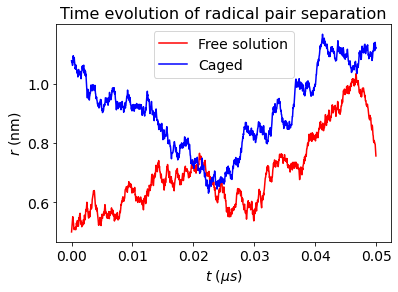

In [10]:
t_max = 50e-9
diffusion = 0.01e-6  # High viscosity solvent = 0.01e-6, water = 1e-6
r_max = 1.5e-9

pos, dist, ang, t = monte_carlo_free(t_max, diffusion, plot=False)
pos_cage, dist_cage, ang_cage, t = monte_carlo_caged(t_max, diffusion, r_max, plot=False)

t_convert = 1e-6

plt.clf()
plt.grid(False)
plt.axis("on")
plt.rc("axes", edgecolor="k")
plt.plot(t / t_convert, dist * 1e9, "r")
plt.plot(t / t_convert, dist_cage * 1e9, "b")
plt.title("Time evolution of radical pair separation", size=16)
plt.legend(["Free solution", "Caged"], fontsize=14)
plt.xlabel("$t$ ($\mu s$)", size=14)
plt.ylabel("$r$ (nm)", size=14)
plt.tick_params(labelsize=14)

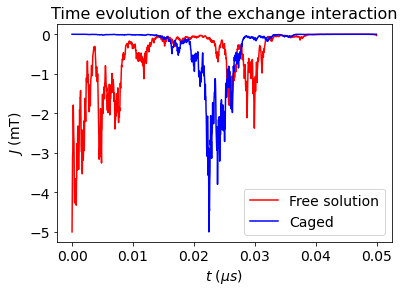

In [13]:
J = rp.estimations.exchange_interaction_in_solution_MC(dist, J0=-5)
J_cage = rp.estimations.exchange_interaction_in_solution_MC(dist_cage, J0=-5)

plt.grid(False)
plt.axis("on")
plt.rc("axes", edgecolor="k")
plt.plot(t / t_convert, J, "r")
plt.plot(t / t_convert, J_cage, "b")
plt.title("Time evolution of the exchange interaction", size=16)
plt.legend(["Free solution", "Caged"], fontsize=14)
plt.xlabel("$t$ ($\mu s$)", size=14)
plt.ylabel("$J$ (mT)", size=14)
plt.tick_params(labelsize=14)

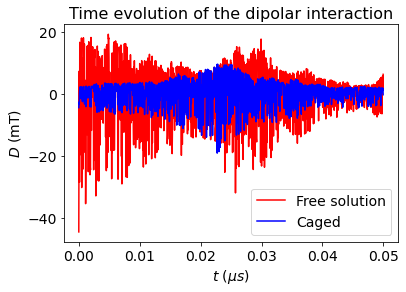

In [14]:
D = rp.estimations.dipolar_interaction_MC(dist, ang)
D_cage = rp.estimations.dipolar_interaction_MC(dist_cage, ang_cage)

plt.grid(False)
plt.axis("on")
plt.rc("axes", edgecolor="k")
plt.plot(t / t_convert, D, "r")
plt.plot(t / t_convert, D_cage, "b")
plt.title("Time evolution of the dipolar interaction", size=16)
plt.legend(["Free solution", "Caged"], fontsize=14)
plt.xlabel("$t$ ($\mu s$)", size=14)
plt.ylabel("$D$ (mT)", size=14)
plt.tick_params(labelsize=14)

---

### Estimating spin dephasing rate constants

The equations for estimating spin dephasing rate constants are based on those found in [D. R. Kattnig, J. K. Sowa, I. A. Solov'yov, and P. J. Hore, *New J. Phys.* **18** (2016) 063007](https://iopscience.iop.org/article/10.1088/1367-2630/18/6/063007). 

The rate ($k_{STD}$) for spin relaxation arising from *J*-modulation is given by,

$$
k_{STD} = 4\langle[(J(r(t)) - J_{av})^2]\rangle\tau_c
$$

Similarly, the rate ($k_D$) for spin relaxation arising from *D*-modulation,

$$
k_D = \langle[(D(r(t)) - D_{av})^2]\rangle\tau_c
$$

In [15]:
tau_c = 1e-9  # (s) Correlation time
kSTD = rp.estimations.k_STD(J, tau_c)
kSTD_cage = rp.estimations.k_STD(J_cage, tau_c)
kD = rp.estimations.k_D(D, tau_c)
kD_cage = rp.estimations.k_D(D_cage, tau_c)

print('Solution J-modulation rate (s^-1) =', "{:.2e}".format(kSTD))
print('Caged J-modulation rate (s^-1) =', "{:.2e}".format(kSTD_cage))
print()

print('Solution D-modulation rate (s^-1) =', "{:.2e}".format(kD))
print('Caged D-modulation rate (s^-1) =', "{:.2e}".format(kD_cage))

Solution J-modulation rate (s^-1) = 7.60e+07
Caged J-modulation rate (s^-1) = 5.34e+07

Solution D-modulation rate (s^-1) = 2.75e+09
Caged D-modulation rate (s^-1) = 5.29e+08


---

### Importing MD data (Figure 5 from Antill and Vatai, JCTC, 20, 9488-9499, 2024)

The following molecular dynamics simulation and analysis were performed on a pair of FAD•− WH•+ radicals encapsulated in an AOT reverse micelle (water and isooctane, $w_0$  = 15) in the NAMD/VMD workspace. The centre-of-mass to centre-of-mass (COM−COM) distance of the FAD•− WH•+ radical pair was taken at every time step of the MD simulation to calculate the fluctuations in the exchange interaction, $J$, over time with the `estimations.exchange_interaction_in_solution_MC` function. The value of `J0` was adjusted (J0 = 5) to correspond to the experimentally determined value of $J$ for FAD in aqueous solution.

The MD trajectory shows that the radical pair separates at early time scales and then has numerous re-encounters as time goes on, which is mediated via π−π stacking between the Trp and FAD moieties. The correlation time of the modulation in the exchange interaction induced by π-π stacking can be approximated by autocorrelation and exponential fitting. This can be easily achieved in RadicalPy with the function `estimations.autocorrelation_fit`, which calculates the autocorrelation and fits a multiexponential (default = 100) to the autocorrelation
curve.

The correlation time for the exchange interaction, is 1.65 ns and is used to calculate the spin dephasing rate, kSTD, with the function `estimations.k_STD` that produces a rate of 1.1 × $10^7$ $s^{−1}$. This spin dephasing rate is consistent with experimental results in radical pairs in reverse micelles and is the main cause of spin relaxation in encapsulated radical pairs.

tau c (ns) = 1.65
Reverse micelle J-modulation rate (s^-1) = 1.17e+07


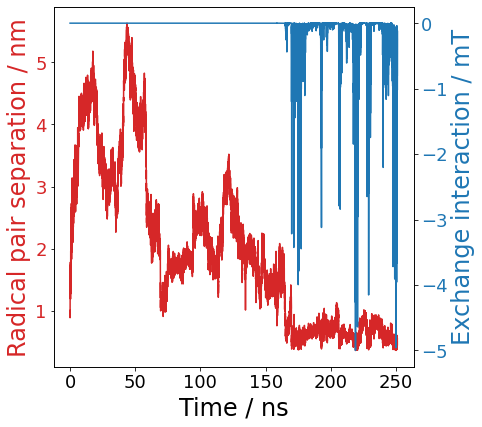

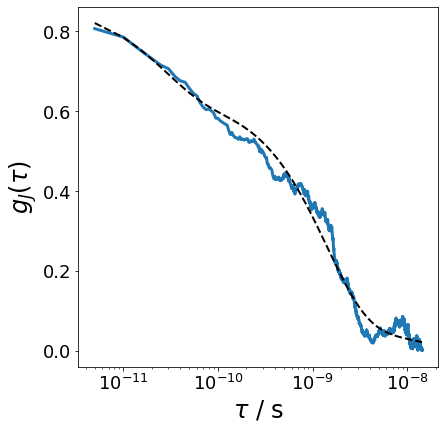

In [4]:
trajectory_data = rp.utils.read_trajectory_files(
    "../data/md_fad_trp_aot", scale=1e-10
)
trajectory_ts = (
    np.linspace(0, len(trajectory_data), len(trajectory_data)) * 5e-12 * 1e9
)
j = rp.estimations.exchange_interaction_in_solution_MC(trajectory_data[:, 1], J0=5)

rp.plot.plot_exchange_interaction_in_solution(trajectory_ts, trajectory_data, j)

acf_j = rp.utils.autocorrelation(j, factor=1)
zero_point_crossing_j = np.where(np.diff(np.sign(acf_j)))[0][0]
t_j_max = max(trajectory_ts[:zero_point_crossing_j]) * 1e-9
t_j = np.linspace(5e-12, t_j_max, zero_point_crossing_j)

acf_j_fit = rp.estimations.autocorrelation_fit(t_j, j, 5e-12, t_j_max)
rp.plot.plot_autocorrelation_fit(t_j, acf_j, acf_j_fit, zero_point_crossing_j)

kstd = rp.estimations.k_STD(-j, acf_j_fit["tau_c"])
print('tau c (ns) =', "{:.2f}".format(acf_j_fit["tau_c"]*1e9))
print('Reverse micelle J-modulation rate (s^-1) =', "{:.2e}".format(kstd))